# 1. Preprocessing Dataset

Overfitting: Monitor train vs validation gap; apply dropout/augmentation

Computational efficiency: Start with smaller images/models, scale up if needed

Reproducibility: Set random seeds for consistent results


Must Have 

✅ Architecture details (layers, filters, activations)

✅ Final hyperparameters (LR, epochs, batch size, optimizer, loss)

✅ Training/Validation accuracy plot

✅ Test accuracy

✅ Precision, Recall, F1 per class

✅ Confusion matrix

✅ Brief analysis/observations


### **B. Data Transformations**:
- **For training**: Augmentation (random rotations, flips, color jitter) + normalize
- **For validation/test**: Just resize + normalize (no augmentation)

### **C. DataLoaders**:
- Train loader with shuffling
- Test/validation loader without shuffling

In [15]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random
import numpy as np

def set_seed(seed=433):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(433)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

# Set matplotlib to display plots inline
%matplotlib inline

# For better plot quality
plt.rcParams['figure.dpi'] = 100

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [16]:
fingers_train_dir = 'data/fingers/train'
fingers_test_dir = 'data/fingers/test'

print(f"Train directory exists: {os.path.exists(fingers_train_dir)}")
print(f"Test directory exists: {os.path.exists(fingers_test_dir)}")

Train directory exists: True
Test directory exists: True


In [17]:
fingers_train_files = os.listdir(fingers_train_dir)
fingers_test_files = os.listdir(fingers_test_dir)

print(f"Total training images: {len(fingers_train_files)}")
print(f"Total test images: {len(fingers_test_files)}")
print(f"\n{'='*50}")
print(f"First 15 training filenames:")
print(f"{'='*50}")
for i, filename in enumerate(fingers_train_files[:15]):
    print(f"{i+1:2d}. {filename}")

Total training images: 18000
Total test images: 3600

First 15 training filenames:
 1. df16050b-6ce3-4a09-8406-f314c9303090_3R.png
 2. ae08efc1-b453-49f3-80f9-d4b3dacd83e0_5R.png
 3. 401d2efa-d6fd-4116-878c-38f4806d8b97_0L.png
 4. 69a97cd5-f3b5-4246-90cc-14173995ffea_2R.png
 5. f510e888-1eec-43c4-9e16-a591e68e47f9_4R.png
 6. c98821ba-4fcc-440b-b74f-87d34b526efa_4L.png
 7. 76de966c-103d-4879-85b4-6bd1c85f968c_1R.png
 8. fa50c7b1-4bf8-412d-a979-b6cc75029b65_5L.png
 9. 608e588f-ca5a-4e1a-82ba-bed244920c16_3R.png
10. 8fdd76c0-5615-4e87-b88c-496fcc20840d_1R.png
11. 38f0a970-957f-42b4-b5d9-7f1e1d8a3fa5_0R.png
12. 9640b47c-c37f-45ea-925c-21f380662adb_1R.png
13. a64a2165-6442-4430-b4db-8b58f384e471_4R.png
14. 6615d35f-14c1-4909-b069-6d6f936a7ce2_4R.png
15. 572ff08a-f791-4d7b-8a97-1a169b98b2e7_5R.png


### We are going to ommit the 'R' or 'L' completly since the assignment only tlks about categorising 3,4,5 and didn't mention right or left.

In [18]:
def extract_label(filename):
    try:
        name = filename.split('.')[0]
        label_part = name.split('_')[-1]
        digit = label_part[0]
        return int(digit)
    except:
        print(f"Warning: Could not parse {filename}")
        return None
    
print(f"{'Filename':<40} -> Label")
print("="*50)
for filename in fingers_train_files[:5]:
    label = extract_label(filename)
    print(f"{filename:<40} -> {label}")

Filename                                 -> Label
df16050b-6ce3-4a09-8406-f314c9303090_3R.png -> 3
ae08efc1-b453-49f3-80f9-d4b3dacd83e0_5R.png -> 5
401d2efa-d6fd-4116-878c-38f4806d8b97_0L.png -> 0
69a97cd5-f3b5-4246-90cc-14173995ffea_2R.png -> 2
f510e888-1eec-43c4-9e16-a591e68e47f9_4R.png -> 4


### Checking for Class imbalances

In [19]:
train_labels = []
for f in fingers_train_files:
    if f.endswith(('.jpg', '.png', '.jpeg')):
        label = extract_label(f)
        if label is not None:
            train_labels.append(label)

label_counts = Counter(train_labels)

print(f"\n{'='*50}")
print(f"Class Distribution in Training Set:")
print(f"{'='*50}")
for class_num in sorted(label_counts.keys()):
    print(f"Class {class_num}: {label_counts[class_num]:4d} images")
print(f"{'='*50}")
print(f"Total: {sum(label_counts.values())} images")


Class Distribution in Training Set:
Class 0: 3000 images
Class 1: 3000 images
Class 2: 3000 images
Class 3: 3000 images
Class 4: 3000 images
Class 5: 3000 images
Total: 18000 images


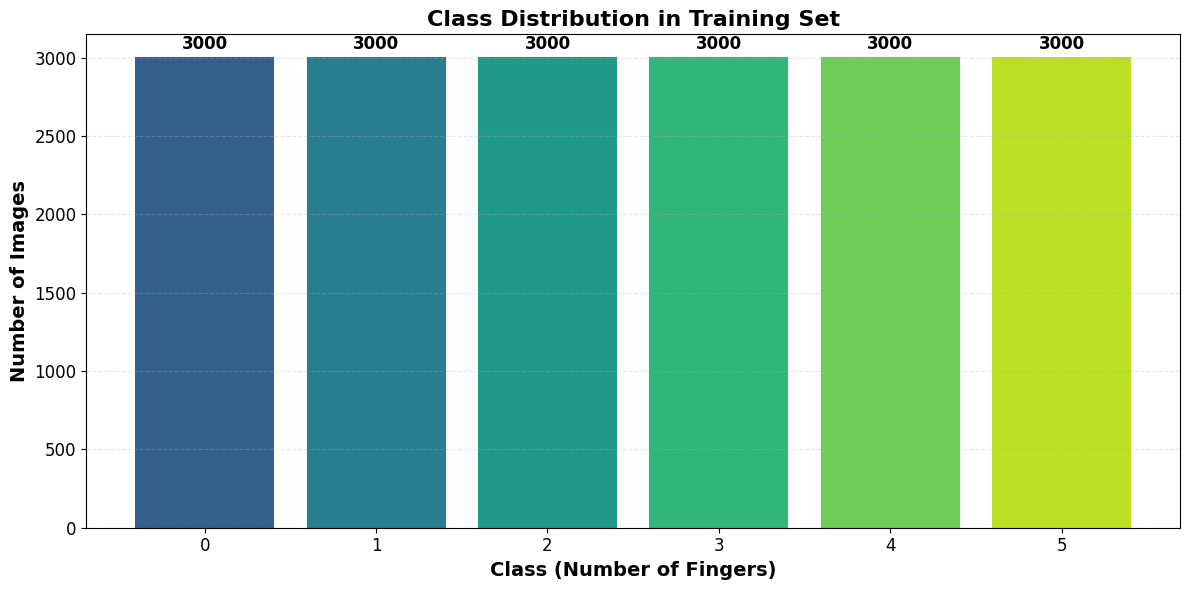

In [20]:
plt.figure(figsize=(12, 6))

classes = sorted(label_counts.keys())
counts = [label_counts[c] for c in classes]

bars = plt.bar(classes, counts, color='skyblue', edgecolor='navy', linewidth=1.5)

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(classes)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.xlabel('Class (Number of Fingers)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Images', fontsize=14, fontweight='bold')
plt.title('Class Distribution in Training Set', fontsize=16, fontweight='bold')
plt.xticks(classes, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')

for cls, count in zip(classes, counts):
    plt.text(cls, count + max(counts)*0.01, str(count), 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
print("Checking image dimensions from random samples...\n")
print(f"{'Filename':<45} {'Width':<8} {'Height':<8} {'Mode':<8}")
print("="*75)

sample_files = random.sample(fingers_train_files, min(10, len(fingers_train_files)))

widths = []
heights = []

for filename in sample_files:
    if filename.endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(fingers_train_dir, filename)
        img = Image.open(img_path)
        width, height = img.size
        widths.append(width)
        heights.append(height)
        print(f"{filename:<45} {width:<8} {height:<8} {img.mode:<8}")

print("="*75)
print(f"\nImage Statistics:")
print(f"  Most common width:  {max(set(widths), key=widths.count)}")
print(f"  Most common height: {max(set(heights), key=heights.count)}")
print(f"  Width range: {min(widths)} - {max(widths)}")
print(f"  Height range: {min(heights)} - {max(heights)}")

if len(set(widths)) == 1 and len(set(heights)) == 1:
    print(f"\nAll images have the SAME dimensions: {widths[0]}x{heights[0]}")
else:
    print(f"\nImages have DIFFERENT dimensions - we'll need to resize them")

Checking image dimensions from random samples...

Filename                                      Width    Height   Mode    
584e7e1a-8a38-48b8-8d00-a67734d57d3d_3L.png   128      128      L       
b1da3784-b409-4f5a-ae32-5e3a63ba52d9_3R.png   128      128      L       
20e6622e-c11c-4204-a1e9-140ed481d2b8_4R.png   128      128      L       
4f3a51f6-543b-4712-ad8a-aa5026a7d8bf_5R.png   128      128      L       
4e2b0ae3-e55a-4168-9c03-ef09bc3402dc_0R.png   128      128      L       
65de1b21-a7be-4a2b-b31d-e7eeeca6de77_4R.png   128      128      L       
f11052dd-efe8-441a-8d81-2a81e64ab281_0L.png   128      128      L       
5951b638-5654-45ce-a10a-c07c0d46f142_1L.png   128      128      L       
369b4cce-0e4a-4b06-975c-5ef1919fcc70_3R.png   128      128      L       
d592eb1d-0195-4354-b07b-4290d921cb6f_2L.png   128      128      L       

Image Statistics:
  Most common width:  128
  Most common height: 128
  Width range: 128 - 128
  Height range: 128 - 128

All images have the SAME

## 2. CNN architecture

## 3. Training Loop

## 4. Evaluation